# Operator exponential tutorial

In this tutorial, we will illustrate the solution to a simple but canonical PDE (the heat/diffusion equation) using the exponential of the *linear* operator. We need the following Julia packages, and we'll especially take advantage of `ApproxFun`, which we briefly introduced in [this tutorial](https://github.com/mjyshin/math-tutorials/blob/main/picard_iteration.ipynb):

In [1]:
using LinearAlgebra, ApproxFun, Plots, LaTeXStrings

(I did not author most of this code; the bulk of the computation in `exp` below is from [`ApproxFunExamples`](https://github.com/JuliaApproximation/ApproxFunExamples/blob/master/PDEs/Heat%20equation.jl) with very minor changes to make it more programmatic. Credit goes out to Dr. Sheehan Olver.)

## PDE model

The well known **heat equation** in the spatial domain $X:=[0,1]$

In [2]:
X = Chebyshev(0..1)

Chebyshev(0..1)

with one model parameter (diffusion constant) $D=0.05$

In [3]:
θ = (D=0.05,)

(D = 0.05,)

is written as the second-order PDE

$$
\begin{equation}
\frac{\partial u}{\partial t}(x,t) = D\Delta u(x,t),\quad x\in X\setminus\partial X,\label{eq:pde}\tag{1}
\end{equation}
$$

where we define the linear operator $L:=D\Delta$.

In [4]:
D = Derivative(X)
Δ = D^2
L = θ.D*Δ

ConstantTimesOperator : Chebyshev(0..1) → Ultraspherical(2,0..1)
 ⋅  ⋅  0.8   ⋅                   ⋅    ⋅   …   ⋅                   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅   1.2000000000000002   ⋅    ⋅       ⋅                   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                  1.6   ⋅       ⋅                   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅   2.0      ⋅                   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅       ⋅                   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅   …  2.8000000000000003   ⋅    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅       ⋅                  3.2   ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅       ⋅                   ⋅   3.6  ⋅
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅       ⋅                   ⋅    ⋅   ⋱
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅       ⋅                   ⋅    ⋅   ⋱
 ⋅  ⋅   ⋅    ⋅                   ⋅    ⋅   …   ⋅                   ⋅    ⋅   ⋱

We will let the IC be the rounded $\text{rect}$ function

$$
u(x,0) = u_0(x) := \frac{1}{2}\left\{ \tanh\left(\frac{x-0.3}{\varepsilon}\right)-\tanh\left(\frac{x-0.7}{\varepsilon}\right) \right\},
$$

where $\varepsilon=10^{-1.5}$.

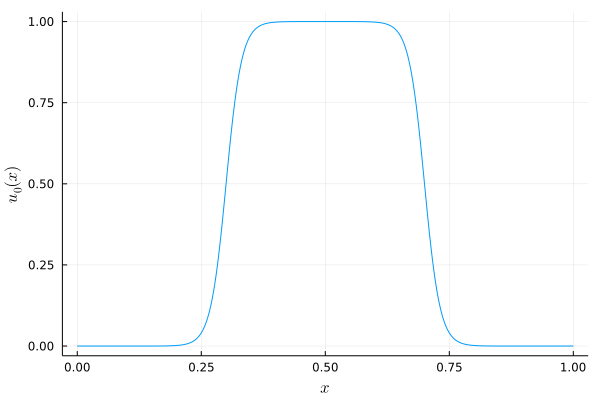

In [5]:
ϵ = 10^(-1.5)
u0 = Fun(x->(tanh((x-0.3)/ϵ)-tanh((x-0.7)/ϵ))/2,X)

fig1 = plot(u0,xlabel=L"x",ylabel=L"u_0(x)",legend=false,fmt=:png)
display(fig1)

Also, we set the left Dirichlet BC as $u(0,t) = u_0(0)$ and the right Neumann BC as $\dfrac{\partial u}{\partial x}(1,t) = \dfrac{\text{d}u_0}{\text{d}x}(1)$.

In [6]:
B = [ldirichlet(X);rneumann(X)]

InterlaceOperator : Chebyshev(0..1) → 2-element ArraySpace:
ConstantSpace{DomainSets.Point{Int64}, Float64}[ConstantSpace(Point(0)), ConstantSpace(Point(1))]
 1.0  -1.0  1.0  -1.0   1.0  -1.0   1.0  -1.0    1.0   -1.0  ⋯
 0.0   2.0  8.0  18.0  32.0  50.0  72.0  98.0  128.0  162.0  ⋯

## $C_0$-semigroup

We can consider Eq. ([1](#mjx-eqn-eq:pde)) as an infinite dimensional ODE on the time-dependent vector $\mathbf{u}(t)$:

$$
\frac{\text{d}\mathbf{u}(t)}{\text{d}t} = L\mathbf{u}(t),\label{eq:ode}\tag{2}
$$

where the linear operator $L$ can be thought of as an "$\infty\times\infty$" matrix. In this context, we hope (skipping the proof) to solve Eq. ([2](#mjx-eqn-eq:ode)) like an ODE to arrive at the solution

$$
\mathbf{u}(t) = e^{Lt}\mathbf{u}_0.\label{eq:soln}\tag{3}
$$

While ([3](#mjx-eqn-eq:soln)) may look innocuous, the operator exponential $e^{Lt}$ is rather complicated. In general, it can be formally expressed as the series expansion

$$
e^{A} = \sum_{n=0}^{\infty} \frac{A^n}{n!}
$$

as with the scalar $e^a$. The operator version is further complicated by the fact that the operator must include the BCs $B$, in addition to the linear dynamic model $L$. We will call this "merged" operator $A$. The 1-parameter (i.e., $t$) operator $T(t):=e^{At}$ and the set of all compositions of them form what is called the **$C_0$-semigroup** (more specifically a monoid?), with the identity element $I:=T(0)$ and the commutative composition operation such that $T(t+s)=T(t)\circ T(s)$ also belongs to the semigroup. In this language, $L$ is known as the **infinitesimal generator** of the $C_0$-semigroup such that

$$
A\mathbf{u} = \lim_{t\to0^+}\frac{T(t)\mathbf{u}-\mathbf{u}}{t}
$$

 We won't attempt to compute $e^{At}$ explicitly but rather overload Julia's (matrix) exponential function `exp` to compute $e^{At}\mathbf{u}_0$ given the `ApproxFun` object $\mathbf{u}_0$. This is similar to how MATLAB's `Chebfun` package overloads its matrix exponential function [`expm`](https://github.com/chebfun/chebfun/blob/master/%40chebop/expm.m).

In [7]:
import Base.exp

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    C = I : domainspace(L) → rangespace(L)    # `I` from LinearAlgebra
    
    B = B[1:2,1:2]\B[1:2,1:n]
    M = C[1:n-2,1:n]
    M = M - M[:,1:2]*B    # remove degrees of freedom
    A = M[:,3:end]\L[1:n-2,3:n]
    
    c0 = u0.coefficients[1:n]
    r = B*c0    # BC values; assume they stay fixed
    
    c̃ = exp(A*t)*c0[3:n]
    c = [r-B[:,3:end]*c̃;c̃]
    u = Fun(domain(u0),c)
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 35 methods)

Using this function, we can compute the vector solution $\mathbf{u}(t)$ for various times $\{t_k\}$, giving us the value $u(x,t=t_k)$ for any $x$.

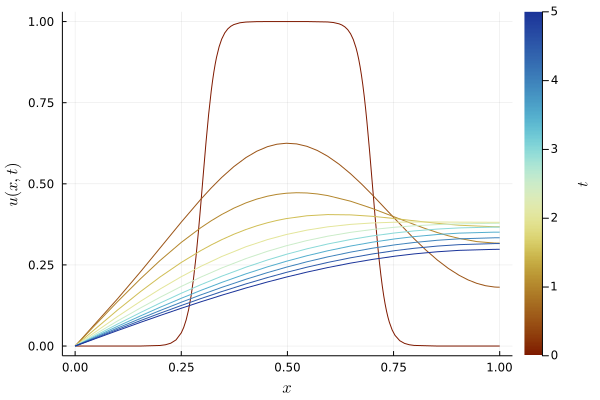

In [8]:
t = 0:0.5:5
u = exp.(Ref(L),Ref(B),t,u0)

fig2 = plot(xlabel=L"x",ylabel=L"u(x,t)",legend=false,fmt=:png)
fig2 = plot!(u,line_z=t',color=:roma,cbar=true,cbartitle=L"t")
display(fig2)

In some future tutorial, we will go over how to solve this simple PDE with `ApproxFun` by extending the 1-D spatial problem to a 2-D spatiotemporal one.

---

## Error!

This method seems to work well for mixed Dirichlet/Neumann BCs, as well as for the case where both BCs are Dirichlet. However, with both Neumann BCs, I get the following error:

In [9]:
B = [lneumann(X);rneumann(X)]
u = exp.(Ref(L),Ref(B),t,u0)

LoadError: LAPACKException(1)